# Beating the Game
### Krissy Gianforte & Dan Kent  
**Final Project --- w207 Section 3, Summer 2018**

## Introduction & Background   

The board game industry has grown dramatically in the last ten years, with an estimated growth of 30% coming by 2021. This growth is not simply due to a resurgence of the classic games like Monopoly and Scrabble; rather, the very basis of board games is changing. In recent years, the target audience has shifted from children to adults, and new mechanics, goals, and styles have emerged. New genres such as cooperative games, multiday adventures, and puzzle quests have come about - and more are being designed all the time.  
Many of these modern board games are getting their start through crowdfunding (for example, Kickstarter). This presents an interesting economic structure: public opinion really determines which games get the chance to come to market. Given only the basic information shared on a Kickstarter page, board game devotees are deciding which games they will support financially.  
This model presents an interesting opportunity not previously available: rather than only seeing the most popular, financed games in big box stores, we have data on *all* size games - even those that failed to win the required funding to actually reach release.  
This project uses that data to explore what exactly makes a board game successful. Our analysis focuses on games from the last ten years in an effort to capture the new trends that have emerged. We use various models to tease out the features that bring high player enjoyment ratings. At the end of our analysis, we apply our modeling theory to a set of games from 1980-1990, to characterize the important features of that era and potentially identify a concrete difference between games released in different decades.  

## Data Intake  

The dataset for this project is taken from the kaggle "board games dataset" page (https://www.kaggle.com/gabrio/board-games-dataset/home). The sqlite database captures data combed from the widely-used board games rating site Board Game Geek (http://www.boardgamegeek.com).  
(The sqlite file is submitted along with this notebook. It must be located in the same directory to read the data.)

In [1]:
# Import packages necessary to read sqlite file

import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
from scipy import stats
import seaborn as sns
sns.set()
pd.set_option('display.max_columns', 100)

In [2]:
#Connect to SQLite DB
conn = sqlite3.connect("database.sqlite")

In [3]:
#Create a cursor Object to allow us to execute SQL queries against the DB
cur = conn.cursor()

In [4]:
#Lets look into the different tables
cur.execute("SELECT name FROM sqlite_master WHERE type='table';")
print(cur.fetchall())

[('BoardGames',), ('bgg.ldaOut.topics',), ('bgg.ldaOut.top.terms',), ('bgg.ldaOut.top.documents',), ('bgg.topics',)]


For this project, we will pull in only the raw data (the BoardGames table) and develop our own models. The raw data is stored in a dataframe called "df_bg".  
(The sqlite database also includes some tables developed as part of the kaggle contest, named "lda_x". We will not use those tables here.)

In [5]:
#Grab the data from the raw BoardGames table
df_bg = pd.read_sql_query("select * from BoardGames", conn)
print("Data loaded.")

Data loaded.


In [6]:
#Close the connection:
cur.close()
conn.close()

## Data Setup & Cleaning   
The Board Games data frame consists of 81 columns (or features) and 90,400 entries. That's a lot of information!   
  
This project hopes to direct board game designers towards qualities that will make their games more successful. In that spirit, we will focus here on features that are under the direct control of the game designer - play time, number of players, mechanics, theme, etc. Our analysis will *not* include input fields that are based on user ratings, since those are only available after a game is released (and therefore would not be available to the game designer during creation).  
  
The output variable for our models will be "success" as measured by player enjoyment using the BoardGameGeek star rating system (a user-submitted 0-10 star rating). Later in this notebook, we will create multiple interpretations of that outcome varaible, including binary "success"/"failure", binned ratings, and the continuous 0-10 scale.

The sections below  
(1) Filter the data to remove irrelevant entries  
(2) Create variables where needed / translate categorical variables into binary fields  
(3) Create a new dataframe containing only the data of interest to us  

### Data Filtering  

In [7]:
# print a bit of the table to visualize
df_bg.head()

,row_names,game.id,game.type,details.description,details.image,details.maxplayers,details.maxplaytime,details.minage,details.minplayers,details.minplaytime,details.name,details.playingtime,details.thumbnail,details.yearpublished,attributes.boardgameartist,attributes.boardgamecategory,attributes.boardgamecompilation,attributes.boardgamedesigner,attributes.boardgameexpansion,attributes.boardgamefamily,attributes.boardgameimplementation,attributes.boardgameintegration,attributes.boardgamemechanic,attributes.boardgamepublisher,attributes.total,stats.average,stats.averageweight,stats.bayesaverage,stats.family.abstracts.bayesaverage,stats.family.abstracts.pos,stats.family.cgs.bayesaverage,stats.family.cgs.pos,stats.family.childrensgames.bayesaverage,stats.family.childrensgames.pos,stats.family.familygames.bayesaverage,stats.family.familygames.pos,stats.family.partygames.bayesaverage,stats.family.partygames.pos,stats.family.strategygames.bayesaverage,stats.family.strategygames.pos,stats.family.thematic.bayesaverage,stats.family.thematic.pos,stats.family.wargames.bayesaverage,stats.family.wargames.pos,stats.median,stats.numcomments,stats.numweights,stats.owned,stats.stddev,stats.subtype.boardgame.bayesaverage,stats.subtype.boardgame.pos,stats.trading,stats.usersrated,stats.wanting,stats.wishing,polls.language_dependence,polls.suggested_numplayers.1,polls.suggested_numplayers.10,polls.suggested_numplayers.2,polls.suggested_numplayers.3,polls.suggested_numplayers.4,polls.suggested_numplayers.5,polls.suggested_numplayers.6,polls.suggested_numplayers.7,polls.suggested_numplayers.8,polls.suggested_numplayers.9,polls.suggested_numplayers.Over,polls.suggested_playerage,attributes.t.links.concat.2....,stats.family.amiga.bayesaverage,stats.family.amiga.pos,stats.family.arcade.bayesaverage,stats.family.arcade.pos,stats.family.atarist.bayesaverage,stats.family.atarist.pos,stats.family.commodore64.bayesaverage,stats.family.commodore64.pos,stats.subtype.rpgitem.bayesaverage,stats.subtype.rpgitem.pos,stats.subtype.videogame.bayesaverage,stats.subtype.videogame.pos
0,1,1,boardgame,Die Macher is a game about seven sequential po...,//cf.geekdo-images.com/images/pic159509.jpg,5.0,240.0,14.0,3.0,240.0,Die Macher,240.0,//cf.geekdo-images.com/images/pic159509_t.jpg,1986.0,Marcus Gschwendtner,"Economic,Negotiation,Political",None,Karl-Heinz Schmiel,None,"Country: Germany,Valley Games Classic Line",None,None,"Area Control / Area Influence,Auction/Bidding,...","Hans im Glück Verlags-GmbH,Moskito Spiele,Vall...",6.0,7.66508,4.3477,7.29168,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.39570,85.0,NaN,NaN,NaN,NaN,0.0,1763.0,719.0,5251.0,1.59321,7.29168,147.0,170.0,4498.0,505.0,1654.0,No,NotRecommended,None,NotRecommended,NotRecommended,Recommended,Best,None,None,None,None,NotRecommended,14,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2,boardgame,Dragonmaster is a trick-taking card game based...,//cf.geekdo-images.com/images/pic184174.jpg,4.0,30.0,12.0,3.0,30.0,Dragonmaster,30.0,//cf.geekdo-images.com/images/pic184174_t.jpg,1981.0,Bob Pepper,"Card Game,Fantasy",None,"G. W. ""Jerry"" D'Arcey",None,Animals: Dragons,"Indulgence,Coup d'etat",None,Trick-taking,"E.S. Lowe,Milton Bradley",7.0,6.60815,1.9423,5.87150,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.91318,1066.0,NaN,NaN,NaN,NaN,0.0,273.0,52.0,1053.0,1.46282,5.87150,2541.0,73.0,478.0,67.0,161.0,Some,NotRecommended,None,NotRecommended,Recommended,Best,None,None,None,None,None,NotRecommended,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,3,boardgame,"Part of the Knizia tile-laying trilogy, Samura...",//cf.geekdo-images.com/images/pic3211873.jpg,4.0,60.0,10.0,2.0,30.0,Samurai,60.0,//cf.geekdo-images.com/images/pic3211873_t.jpg,1998.0,Franz Vohwinkel,"Abstract Strategy,Medieval",None,Reiner Knizia,None,"Asian Theme,Country: Japan,Knizia tile-laying ...",None,None,"Area Control / Area Influence,Hand Management,...","999 Games,ABACUSSPIELE,Astrel Games,Ceilikan J...",6.0,7.44119,2.5085,7.28295,NaN

In [8]:
# Describe the data frame fields and contents
df_bg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90400 entries, 0 to 90399
Data columns (total 81 columns):
row_names                                   90400 non-null object
game.id                                     90400 non-null object
game.type                                   90400 non-null object
details.description                         90400 non-null object
details.image                               83508 non-null object
details.maxplayers                          90397 non-null float64
details.maxplaytime                         90397 non-null float64
details.minage                              90397 non-null float64
details.minplayers                          90397 non-null float64
details.minplaytime                         90397 non-null float64
details.name                                90400 non-null object
details.playingtime                         90397 non-null float64
details.thumbnail                           83508 non-null object
details.yearpublished      

We want to filter out a few types of entries:  
(1) Those with fewer than 10 rating entries [where the results may be biased by a few users]  
(2) Board Game expansions [we will only consider base games here]  
(3) Video games & role-playing books [this analysis focuses on table-top board games]  

We can accomplish this by filtering on the following variables:  
- game.type (filter out non-Board Games to remove expansions)
- stats.usersrated (Filter out less than 10)
- stats.subtype.rpgitem.pos (Filter out)
- stats.subtype.videogame.pos (Filter out)

In [9]:
# Filter out games with fewer than 10 rating entries
# (also filter for published year > 1900 to remove irrelevant data)
df_filter = df_bg[(df_bg['stats.usersrated'] > 10) & 
                    (df_bg['details.yearpublished'] > 1900)]

# Filter out expansions
df_filter = df_filter[(df_filter['game.type']) == "boardgame"]
# NOTE: expansions have game.type "boardgameexpansion"

# Filter out video games and role-playing books
df_filter = df_filter[(df_filter['stats.subtype.rpgitem.pos'].isnull()) & 
                          (df_filter['stats.subtype.videogame.pos'].isnull())]

# Final filtered data frame:
df_filter.describe()

,details.maxplayers,details.maxplaytime,details.minage,details.minplayers,details.minplaytime,details.playingtime,details.yearpublished,attributes.total,stats.average,stats.averageweight,stats.bayesaverage,stats.family.abstracts.bayesaverage,stats.family.abstracts.pos,stats.family.cgs.bayesaverage,stats.family.cgs.pos,stats.family.childrensgames.bayesaverage,stats.family.childrensgames.pos,stats.family.familygames.bayesaverage,stats.family.familygames.pos,stats.family.partygames.bayesaverage,stats.family.partygames.pos,stats.family.strategygames.bayesaverage,stats.family.strategygames.pos,stats.family.thematic.bayesaverage,stats.family.thematic.pos,stats.family.wargames.bayesaverage,stats.family.wargames.pos,stats.median,stats.numcomments,stats.numweights,stats.owned,stats.stddev,stats.subtype.boardgame.bayesaverage,stats.subtype.boardgame.pos,stats.trading,stats.usersrated,stats.wanting,stats.wishing,stats.family.amiga.bayesaverage,stats.family.amiga.pos,stats.family.arcade.bayesaverage,stats.family.arcade.pos,stats.family.atarist.bayesaverage,stats.family.atarist.pos,stats.family.commodore64.bayesaverage,stats.family.commodore64.pos,stats.subtype.rpgitem.bayesaverage,stats.subtype.rpgitem.pos,stats.subtype.videogame.bayesaverage,stats.subtype.videogame.pos
count,20842.000000,20842.000000,20842.000000,20842.000000,20842.000000,20842.000000,20842.000000,20842.000000,20842.000000,20842.000000,20842.000000,806.000000,798.000000,266.000000,264.000000,650.000000,650.000000,1547.000000,1532.000000,431.000000,426.000000,1645.000000,1625.000000,879.000000,870.000000,2555.000000,2523.000000,20842.0,20842.000000,20842.000000,20842.000000,20842.000000,13656.000000,13483.000000,20842.000000,20842.000000,20842.000000,20842.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,5.341618,76.394828,8.960608,2.054937,67.869590,76.394828,2002.278860,5.483351,6.177499,1.869084,3.747665,5.829950,425.190476,5.963841,132.500000,5.490099,327.836923,5.986206,777.039817,5.955147,215.969484,6.299888,815.225846,6.156519,435.301149,6.017413,1263.164487,0.0,131.236829,38.892429,729.420257,1.518226,5.720150,6814.585552,27.322954,457.413588,30.181077,117.509116,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,14.373976,488.914626,3.997340,0.688318,461.959652,488.914626,13.800454,1.205738,1.008343,0.924572,2.737987,0.439721,245.290075,0.749003,76.354437,0.560599,190.252685,0.484513,447.814427,0.580266,124.543124,0.602057,471.140369,0.610644,251.027497,0.494920,730.036972,0.0,464.393914,173.669855,2842.386204,0.343919,0.398324,3940.078844,70.036042,2102.773633,98.820719,447.580727,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1901.000000,1.000000,1.226530,0.000000,0.000000,4.698510,1.000000,3.627810,1.000000,2.871180,1.000000,4.093260,1.000000,3.383350,1.000000,4.915410,1.000000,4.850390,1.000000,4.494430,1.000000,0.0,0.000000,0.000000,0.000000,0.369966,3.713330,1.000000,0.000000,11.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,2.000000,20.000000,8.000000,2.000000,20.000000,20.000000,1996.000000,5.000000,5.556000,1.181800,0.000000,5.538267,212.500000,5.463457,66.750000,5.188495,163.250000,5.631495,389.750000,5.586265,109.250000,5.795290,407.000000,5.677385,218.250000,5.670540,631.500000,0.0,10.000000,2.000000,54.000000,1.296360,5.513438,3401.000000,2.000000,21.000000,1.000000,5.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,4.000000,40.000000,10.000000,2.000000,30.000000,40.000000,2007.000000,5.000000,6.219970,1.833300,5.510885,5.729110,422.500000,5.823545,132.500000,5.490630,326.500000,5.892270,778.500000,5.886040,215.500000,6.184040,815.000000,5.989790,435.500000,5.900000,1262.000000,0.0,25.000000,6.000000,136.000000,1.470660,5.569265,6811.000000,7.000000,52.000000,5.000000,14.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,6.000000,90.000000,12.000000,2.000000,60.000000,90.000000,2012.000000,6.000000,6.861903,2.500000,5.617965,6.046375

### Processing Feature Variables

As discussed above, this analysis focuses on the aspects of a board game that designers can directly control. Those features are given in the variables below:  

###### Features
- details.maxplayers
- details.minage
- details.minplayers
- details.playingtime
- details.yearpublished
- attributes.boardgamecategory (will require pre-processing)
- attributes.boardgamemechanic (will require pre-processing)
- stats.averageweight (NOTE: this is a sort of  complexity rating for gameplay)

###### Other Fields
- We'll keep details.name to be able to refer to specific games  


A bit of pre-processing is required to make the Category and Mechanic fields more usable. The given database records these things in comma-separated lists, whereas we need a set of binary fields (one per category and mechanic). The cells below perform the preprocessing on the boardgamecategory and boardgamemechanic variables. 

In [10]:
# Next we'll try to pre-process attributes.boardgamemechanic	

df_mechs = df_filter['attributes.boardgamemechanic'].str.get_dummies(sep=',')

In [11]:
df_mechs.head()

,Acting,Action / Movement Programming,Action Point Allowance System,Area Control / Area Influence,Area Enclosure,Area Movement,Area-Impulse,Auction/Bidding,Betting/Wagering,Campaign / Battle Card Driven,Card Drafting,Chit-Pull System,Co-operative Play,Commodity Speculation,Crayon Rail System,Deck / Pool Building,Dice Rolling,Grid Movement,Hand Management,Hex-and-Counter,Line Drawing,Memory,Modular Board,Paper-and-Pencil,Partnerships,Pattern Building,Pattern Recognition,Pick-up and Deliver,Player Elimination,Point to Point Movement,Press Your Luck,Rock-Paper-Scissors,Role Playing,Roll / Spin and Move,Route/Network Building,Secret Unit Deployment,Set Collection,Simulation,Simultaneous Action Selection,Singing,Stock Holding,Storytelling,Take That,Tile Placement,Time Track,Trading,Trick-taking,Variable Phase Order,Variable Player Powers,Voting,Worker Placement
0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0
3,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0


In [12]:
df_mechs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20842 entries, 0 to 90327
Data columns (total 51 columns):
Acting                           20842 non-null int64
Action / Movement Programming    20842 non-null int64
Action Point Allowance System    20842 non-null int64
Area Control / Area Influence    20842 non-null int64
Area Enclosure                   20842 non-null int64
Area Movement                    20842 non-null int64
Area-Impulse                     20842 non-null int64
Auction/Bidding                  20842 non-null int64
Betting/Wagering                 20842 non-null int64
Campaign / Battle Card Driven    20842 non-null int64
Card Drafting                    20842 non-null int64
Chit-Pull System                 20842 non-null int64
Co-operative Play                20842 non-null int64
Commodity Speculation            20842 non-null int64
Crayon Rail System               20842 non-null int64
Deck / Pool Building             20842 non-null int64
Dice Rolling               

In [13]:
mechs_selector = list(df_mechs)

In [14]:
df_cats = df_filter['attributes.boardgamecategory'].str.get_dummies(sep=',')

In [15]:
df_cats.head()

,Abstract Strategy,Action / Dexterity,Adventure,Age of Reason,American Civil War,American Indian Wars,American Revolutionary War,American West,Ancient,Animals,Arabian,Aviation / Flight,Bluffing,Book,Card Game,Children's Game,City Building,Civil War,Civilization,Collectible Components,Comic Book / Strip,Deduction,Dice,Economic,Educational,Electronic,Environmental,Expansion for Base-game,Exploration,Fan Expansion,Fantasy,Farming,Fighting,Game System,Horror,Humor,Industry / Manufacturing,Korean War,Mafia,Math,Mature / Adult,Maze,Medical,Medieval,Memory,Miniatures,Modern Warfare,Movies / TV / Radio theme,Murder/Mystery,Music,Mythology,Napoleonic,Nautical,Negotiation,Novel-based,Number,Party Game,Pike and Shot,Pirates,Political,Post-Napoleonic,Prehistoric,Print & Play,Puzzle,Racing,Real-time,Religious,Renaissance,Science Fiction,Space Exploration,Spies/Secret Agents,Sports,Territory Building,Trains,Transportation,Travel,Trivia,Video Game Theme,Vietnam War,Wargame,Word Game,World War I,World War II,Zombies
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [16]:
df_cats.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20842 entries, 0 to 90327
Data columns (total 84 columns):
Abstract Strategy             20842 non-null int64
Action / Dexterity            20842 non-null int64
Adventure                     20842 non-null int64
Age of Reason                 20842 non-null int64
American Civil War            20842 non-null int64
American Indian Wars          20842 non-null int64
American Revolutionary War    20842 non-null int64
American West                 20842 non-null int64
Ancient                       20842 non-null int64
Animals                       20842 non-null int64
Arabian                       20842 non-null int64
Aviation / Flight             20842 non-null int64
Bluffing                      20842 non-null int64
Book                          20842 non-null int64
Card Game                     20842 non-null int64
Children's Game               20842 non-null int64
City Building                 20842 non-null int64
Civil War               

In [17]:
cats_selector = list(df_cats)

In [18]:
#Now let's create a new Dataframe with only the features we want to keep
df_limit = df_filter[['details.name','details.maxplayers', 'details.minage', 'details.minplayers', 'details.playingtime', 'details.yearpublished', 'stats.averageweight', 'stats.average', 'stats.owned', 'stats.stddev'].copy()]

In [19]:
df_limit.head(10)

,details.name,details.maxplayers,details.minage,details.minplayers,details.playingtime,details.yearpublished,stats.averageweight,stats.average,stats.owned,stats.stddev
0,Die Macher,5.0,14.0,3.0,240.0,1986.0,4.3477,7.66508,5251.0,1.59321
1,Dragonmaster,4.0,12.0,3.0,30.0,1981.0,1.9423,6.60815,1053.0,1.46282
2,Samurai,4.0,10.0,2.0,60.0,1998.0,2.5085,7.44119,11870.0,1.18531
3,Tal der Könige,4.0,12.0,2.0,60.0,1992.0,2.6667,6.60675,523.0,1.21028
4,Acquire,6.0,12.0,3.0,90.0,1964.0,2.5089,7.35830,18682.0,1.33020
5,Mare Mediterraneum,6.0,12.0,2.0,240.0,1989.0,3.0000,6.52534,106.0,1.65064
6,Cathedral,2.0,8.0,2.0,20.0,1978.0,1.8217,6.50534,4561.0,1.31078
7,Lords of Creation,5.0,12.0,2.0,120.0,1993.0,2.4000,6.14538,460.0,1.25508
8,El Caballero,4.0,13.0,2.0,90.0,1998.0,3.1958,6.51776,2263.0,1.40413
9,Elfenland,6.0,10.0,2.0,60.0,1998.0,2.1649,6.74996,7792.0,1.24616


In [20]:
df_interim = df_cats.join(df_mechs, lsuffix='_category', rsuffix='_mechanics')

In [21]:
df_interim.head()

,Abstract Strategy,Action / Dexterity,Adventure,Age of Reason,American Civil War,American Indian Wars,American Revolutionary War,American West,Ancient,Animals,Arabian,Aviation / Flight,Bluffing,Book,Card Game,Children's Game,City Building,Civil War,Civilization,Collectible Components,Comic Book / Strip,Deduction,Dice,Economic,Educational,Electronic,Environmental,Expansion for Base-game,Exploration,Fan Expansion,Fantasy,Farming,Fighting,Game System,Horror,Humor,Industry / Manufacturing,Korean War,Mafia,Math,Mature / Adult,Maze,Medical,Medieval,Memory_category,Miniatures,Modern Warfare,Movies / TV / Radio theme,Murder/Mystery,Music,...,Action / Movement Programming,Action Point Allowance System,Area Control / Area Influence,Area Enclosure,Area Movement,Area-Impulse,Auction/Bidding,Betting/Wagering,Campaign / Battle Card Driven,Card Drafting,Chit-Pull System,Co-operative Play,Commodity Speculation,Crayon Rail System,Deck / Pool Building,Dice Rolling,Grid Movement,Hand Management,Hex-and-Counter,Line Drawing,Memory_mechanics,Modular Board,Paper-and-Pencil,Partnerships,Pattern Building,Pattern Recognition,Pick-up and Deliver,Player Elimination,Point to Point Movement,Press Your Luck,Rock-Paper-Scissors,Role Playing,Roll / Spin and Move,Route/Network Building,Secret Unit Deployment,Set Collection,Simulation,Simultaneous Action Selection,Singing,Stock Holding,Storytelling,Take That,Tile Placement,Time Track,Trading,Trick-taking,Variable Phase Order,Variable Player Powers,Voting,Worker Placement
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0


In [22]:
df_data = df_limit.join(df_interim)

In [23]:
df_data

,details.name,details.maxplayers,details.minage,details.minplayers,details.playingtime,details.yearpublished,stats.averageweight,stats.average,stats.owned,stats.stddev,Abstract Strategy,Action / Dexterity,Adventure,Age of Reason,American Civil War,American Indian Wars,American Revolutionary War,American West,Ancient,Animals,Arabian,Aviation / Flight,Bluffing,Book,Card Game,Children's Game,City Building,Civil War,Civilization,Collectible Components,Comic Book / Strip,Deduction,Dice,Economic,Educational,Electronic,Environmental,Expansion for Base-game,Exploration,Fan Expansion,Fantasy,Farming,Fighting,Game System,Horror,Humor,Industry / Manufacturing,Korean War,Mafia,Math,...,Action / Movement Programming,Action Point Allowance System,Area Control / Area Influence,Area Enclosure,Area Movement,Area-Impulse,Auction/Bidding,Betting/Wagering,Campaign / Battle Card Driven,Card Drafting,Chit-Pull System,Co-operative Play,Commodity Speculation,Crayon Rail System,Deck / Pool Building,Dice Rolling,Grid Movement,Hand Management,Hex-and-Counter,Line Drawing,Memory_mechanics,Modular Board,Paper-and-Pencil,Partnerships,Pattern Building,Pattern Recognition,Pick-up and Deliver,Player Elimination,Point to Point Movement,Press Your Luck,Rock-Paper-Scissors,Role Playing,Roll / Spin and Move,Route/Network Building,Secret Unit Deployment,Set Collection,Simulation,Simultaneous Action Selection,Singing,Stock Holding,Storytelling,Take That,Tile Placement,Time Track,Trading,Trick-taking,Variable Phase Order,Variable Player Powers,Voting,Worker Placement
0,Die Macher,5.0,14.0,3.0,240.0,1986.0,4.3477,7.66508,5251.0,1.593210,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1,Dragonmaster,4.0,12.0,3.0,30.0,1981.0,1.9423,6.60815,1053.0,1.462820,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,Samurai,4.0,10.0,2.0,60.0,1998.0,2.5085,7.44119,11870.0,1.185310,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0
3,Tal der Könige,4.0,12.0,2.0,60.0,1992.0,2.6667,6.60675,523.0,1.210280,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Acquire,6.0,12.0,3.0,90.0,1964.0,2.5089,7.35830,18682.0,1.330200,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0
5,Mare Mediterraneum,6.0,12.0,2.0,240.0,1989.0,3.0000,6.52534,106.0,1.650640,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,Cathedral,2.0,8.0,2.0,20.0,1978.0,1.8217,6.50534,4561.0,1.310780,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
7,Lords of Creation,5.0,12.0,2.0,120.0,1993.0,2.4000,6.14538,460.0,1.255080,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,El Caballero,4.0,13.0,2.0,90.0,1998.0,3.1958,6.51776,2263.0,1.404130,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
9,Elfenland,6.0,10.0,2.0,60.0,1998.0,2.1649,6.74996,7792.0,1.246160,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,...,

In [24]:
len(df_cats.columns) + len(df_mechs.columns) + len(df_limit.columns) - len(df_data.columns) == 0

True

In [25]:
#Check if there are any NaNs
nanlist = df_data.isnull().sum(axis=1).tolist()

for i in nanlist:
    if i != 0:
        print("Boop")
print("done")

done


In [26]:
#We see that there are some games that have the same name, but not that many.  
df_data['details.name'].value_counts()

Robin Hood                                     5
Mafia                                          5
Cosmic Encounter                               4
Gangster                                       4
Quicksand                                      4
Chaos                                          4
Samurai                                        4
Saga                                           4
Grand Prix                                     4
Vegas                                          4
Battle of the Bulge                            3
Around the World in 80 Days                    3
Versailles                                     3
Combat                                         3
Polarity                                       3
Artifact                                       3
Dallas                                         3
The Hobbit: An Unexpected Journey              3
Horus Heresy                                   3
Austerlitz                                     3
En Garde!           

### Processing Response Variables  
The output variable for this analysis will be "success", as measured by the player enjoyment rating (using a 10-star likert scale).
The variables listed below capture this outcome in various ways.  

###### Response Variables
- stats.average (0-10 stars)  
- stats.stddev (for average star rating)  


We'll make two adjustments to our outcome variable. 
  - As given, the stats.average variable is a continuous variable between 0 and 10. Our models will work best with a finite number of outcome groups, so we'll bin the rating by star levels. To keep things simple, we'll round down each star rating to a whole number (so 5.7 will become 5, for example). This will be stored as "binned_average".
  - Some of our models may work best with a binary outcome measurement. For that, we can create a binary measure for the player enjoyment rating. Games with an average rating greater than 7 are considered successful, and those less than 7 are considered unsuccessful. (This threshold is set based on our experience, and has no concrete mathematical derivation.) We'll store these values as the integers 1 (success) and 0 (unsuccessful).

In [27]:
df_data['binned.average'] = np.floor(df_data['stats.average'])
df_data['binary.success'] = (df_data['binned.average'] > 6.5)*1

## Exporatory Data Analaysis  
With our new data frame, we can conduct an EDA to begin to look at the data. This will help us perform any additional filtering or processing that is necessary; it may also help reveal insights into game trends.   

The cells below explore the key variables in our dataset. We also investigate apparent outliers, to see if they should be removed from the analysis.   

In [28]:
import matplotlib.pyplot as plt
def analyze_feature(data, feat_name):
    print(data[feat_name].describe())
    plt.figure(figsize = (20,5))
    plt.subplot(1,3,2)
    sns.distplot(data[feat_name])
    plt.subplot(1,3,3)
    sns.boxplot(data[feat_name])

#### MaxPlayers

count    20842.000000
mean         5.341618
std         14.373976
min          0.000000
25%          2.000000
50%          4.000000
75%          6.000000
max        999.000000
Name: details.maxplayers, dtype: float64


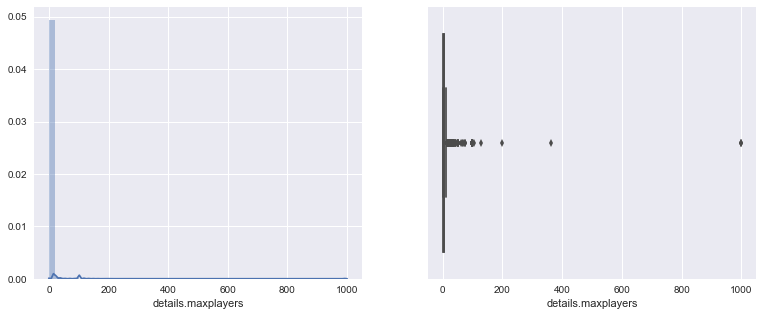

In [29]:
analyze_feature(df_data, "details.maxplayers")

In [30]:
df_data.loc[df_data['details.maxplayers']==999]

,details.name,details.maxplayers,details.minage,details.minplayers,details.playingtime,details.yearpublished,stats.averageweight,stats.average,stats.owned,stats.stddev,Abstract Strategy,Action / Dexterity,Adventure,Age of Reason,American Civil War,American Indian Wars,American Revolutionary War,American West,Ancient,Animals,Arabian,Aviation / Flight,Bluffing,Book,Card Game,Children's Game,City Building,Civil War,Civilization,Collectible Components,Comic Book / Strip,Deduction,Dice,Economic,Educational,Electronic,Environmental,Expansion for Base-game,Exploration,Fan Expansion,Fantasy,Farming,Fighting,Game System,Horror,Humor,Industry / Manufacturing,Korean War,Mafia,Math,...,Area Control / Area Influence,Area Enclosure,Area Movement,Area-Impulse,Auction/Bidding,Betting/Wagering,Campaign / Battle Card Driven,Card Drafting,Chit-Pull System,Co-operative Play,Commodity Speculation,Crayon Rail System,Deck / Pool Building,Dice Rolling,Grid Movement,Hand Management,Hex-and-Counter,Line Drawing,Memory_mechanics,Modular Board,Paper-and-Pencil,Partnerships,Pattern Building,Pattern Recognition,Pick-up and Deliver,Player Elimination,Point to Point Movement,Press Your Luck,Rock-Paper-Scissors,Role Playing,Roll / Spin and Move,Route/Network Building,Secret Unit Deployment,Set Collection,Simulation,Simultaneous Action Selection,Singing,Stock Holding,Storytelling,Take That,Tile Placement,Time Track,Trading,Trick-taking,Variable Phase Order,Variable Player Powers,Voting,Worker Placement,binned.average,binary.success
23008,Start Player: A Kinda Collectible Card Game,999.0,6.0,2.0,1.0,2006.0,1.0000,6.49793,263.0,1.91599,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6.0,0
26326,"I Don't Know, What Do You Want To Play?",999.0,8.0,2.0,5.0,2007.0,1.0625,6.81325,117.0,1.89398,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,6.0,0
81044,Scrimish Card Game,999.0,8.0,2.0,100.0,2015.0,1.3333,6.13548,297.0,1.60829,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6.0,0


We see from the above analysis, that there are some games that could be considered outliers, as they have values for the maximum number of players, approaching 999 - which in itself might be an artificial contraint that the source imposes on game data input.  Consequently it is the judgement of the investigators to limit the games investigated to a measure of maximum players three positive and negative standard deviations around the mean.  

In [31]:
df_data['details.maxplayers'].mean()

5.341617886959025

In [32]:
df_data['details.maxplayers'].std()

14.373975920228531

In [33]:
df_data['details.maxplayers'].std()*3

43.121927760685594

In [34]:
df_data['details.maxplayers'].mean()+df_data['details.maxplayers'].std()*3

48.46354564764462

We see that the mean number of players is approximately 5.  Consequently three standard deviations below this value is a negative number that does not make sense.  Neither does a board game that can be played with zero players.  Consequently we will set our minimum limit to 1 player.  Our maximum player limit will be 48.46, or rounded to 49 players.

In [35]:
df_data1 = df_data[(df_data['details.maxplayers']>=1) & (df_data['details.maxplayers']<=49)]

count    20367.000000
mean         4.730348
std          2.948834
min          1.000000
25%          3.000000
50%          4.000000
75%          6.000000
max         47.000000
Name: details.maxplayers, dtype: float64


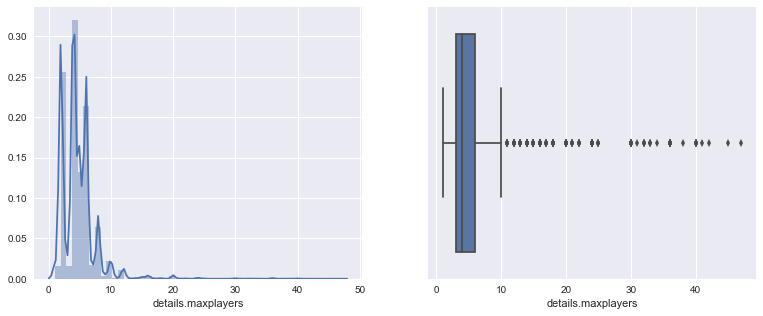

In [36]:
analyze_feature(df_data1, "details.maxplayers")

In [37]:
df_data['details.maxplayers'].count()-df_data1['details.maxplayers'].count()

475

While we still observe a number of outliers based on the box and whisker plot, the investigators believe that this proceedure above will increase the robustness of our analysis.  We observe we have filtered out 475 records.

#### MinAge

count    20367.000000
mean         8.989198
std          3.959902
min          0.000000
25%          8.000000
50%         10.000000
75%         12.000000
max         42.000000
Name: details.minage, dtype: float64


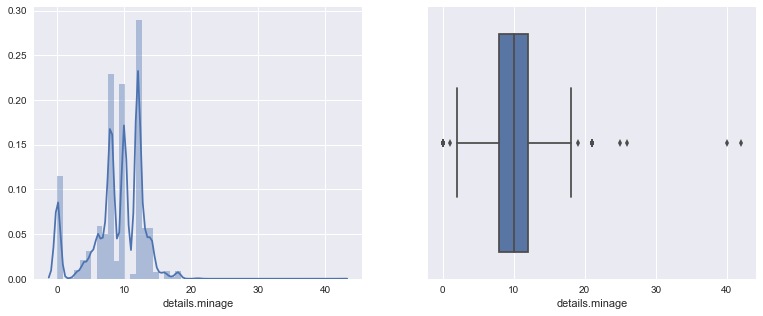

In [38]:
analyze_feature(df_data1, "details.minage")

In [39]:
df_data.loc[df_data['details.minage']==0]

,details.name,details.maxplayers,details.minage,details.minplayers,details.playingtime,details.yearpublished,stats.averageweight,stats.average,stats.owned,stats.stddev,Abstract Strategy,Action / Dexterity,Adventure,Age of Reason,American Civil War,American Indian Wars,American Revolutionary War,American West,Ancient,Animals,Arabian,Aviation / Flight,Bluffing,Book,Card Game,Children's Game,City Building,Civil War,Civilization,Collectible Components,Comic Book / Strip,Deduction,Dice,Economic,Educational,Electronic,Environmental,Expansion for Base-game,Exploration,Fan Expansion,Fantasy,Farming,Fighting,Game System,Horror,Humor,Industry / Manufacturing,Korean War,Mafia,Math,...,Area Control / Area Influence,Area Enclosure,Area Movement,Area-Impulse,Auction/Bidding,Betting/Wagering,Campaign / Battle Card Driven,Card Drafting,Chit-Pull System,Co-operative Play,Commodity Speculation,Crayon Rail System,Deck / Pool Building,Dice Rolling,Grid Movement,Hand Management,Hex-and-Counter,Line Drawing,Memory_mechanics,Modular Board,Paper-and-Pencil,Partnerships,Pattern Building,Pattern Recognition,Pick-up and Deliver,Player Elimination,Point to Point Movement,Press Your Luck,Rock-Paper-Scissors,Role Playing,Roll / Spin and Move,Route/Network Building,Secret Unit Deployment,Set Collection,Simulation,Simultaneous Action Selection,Singing,Stock Holding,Storytelling,Take That,Tile Placement,Time Track,Trading,Trick-taking,Variable Phase Order,Variable Player Powers,Voting,Worker Placement,binned.average,binary.success
100,Peaceful Resistance,3.0,0.0,2.0,30.0,1995.0,0.0000,5.62778,44.0,1.570490,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5.0,0
133,Wortelboer,4.0,0.0,2.0,30.0,1999.0,0.0000,4.11765,37.0,1.996540,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,4.0,0
152,Black Death,6.0,0.0,2.0,120.0,1993.0,1.8421,5.70588,244.0,1.606720,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,5.0,0
221,Politika,7.0,0.0,3.0,0.0,1996.0,1.6667,4.48936,78.0,1.772990,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4.0,0
258,Rossyïa 1917,5.0,0.0,2.0,300.0,1995.0,4.0000,7.25508,189.0,1.280400,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7.0,1
337,Wrott & Swindlers,6.0,0.0,3.0,90.0,1995.0,1.8000,6.48438,57.0,1.118510,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6.0,0
402,Beutelschneider,4.0,0.0,3.0,30.0,1997.0,1.5000,6.03429,95.0,1.376320,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,6.0,0
430,Age of Arguments,4.0,0.0,4.0,120.0,1998.0,0.0000,5.57143,27.0,1.678190,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5.0,0
447,Sufferin' Spirits,4.0,0.0,2.0,120.0,1987.0,2.0000,5.86842,53.0,1.435290,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5.0,0
504,Doolittle & Waite,15.0,0.0,4.0,90.0,1986.0,1.8571,6.21793,149.0,1.240740,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [40]:
df_data.loc[df_data['details.minage']==42]

,details.name,details.maxplayers,details.minage,details.minplayers,details.playingtime,details.yearpublished,stats.averageweight,stats.average,stats.owned,stats.stddev,Abstract Strategy,Action / Dexterity,Adventure,Age of Reason,American Civil War,American Indian Wars,American Revolutionary War,American West,Ancient,Animals,Arabian,Aviation / Flight,Bluffing,Book,Card Game,Children's Game,City Building,Civil War,Civilization,Collectible Components,Comic Book / Strip,Deduction,Dice,Economic,Educational,Electronic,Environmental,Expansion for Base-game,Exploration,Fan Expansion,Fantasy,Farming,Fighting,Game System,Horror,Humor,Industry / Manufacturing,Korean War,Mafia,Math,...,Area Control / Area Influence,Area Enclosure,Area Movement,Area-Impulse,Auction/Bidding,Betting/Wagering,Campaign / Battle Card Driven,Card Drafting,Chit-Pull System,Co-operative Play,Commodity Speculation,Crayon Rail System,Deck / Pool Building,Dice Rolling,Grid Movement,Hand Management,Hex-and-Counter,Line Drawing,Memory_mechanics,Modular Board,Paper-and-Pencil,Partnerships,Pattern Building,Pattern Recognition,Pick-up and Deliver,Player Elimination,Point to Point Movement,Press Your Luck,Rock-Paper-Scissors,Role Playing,Roll / Spin and Move,Route/Network Building,Secret Unit Deployment,Set Collection,Simulation,Simultaneous Action Selection,Singing,Stock Holding,Storytelling,Take That,Tile Placement,Time Track,Trading,Trick-taking,Variable Phase Order,Variable Player Powers,Voting,Worker Placement,binned.average,binary.success
50948,South African Railroads,6.0,42.0,3.0,40.0,2011.0,3.1667,7.58116,89.0,1.24822,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,7.0,1


We observe some interesting records, with a non-trival number of games that have a minimum age of 0, and one game, the infamous game, "South African Railroads," at the maximum extremes.  As there are some board games that might be suitable for children, to distinguish between games that have been mis-inputted, we will set the minimum age to 1.  While not thrilled about including South African Railroad's 42 year minimum age in (but very much morbidly curious), we will nevertheless keep it in.  

In [41]:
df_data2 = df_data1[(df_data1['details.minage']>=1)]

In [42]:
df_data1['details.minage'].count()-df_data2['details.minage'].count()

1971

In [43]:
df_data2['details.minage'].count()

18396

count    18396.000000
mean         9.952327
std          2.788389
min          1.000000
25%          8.000000
50%         10.000000
75%         12.000000
max         42.000000
Name: details.minage, dtype: float64


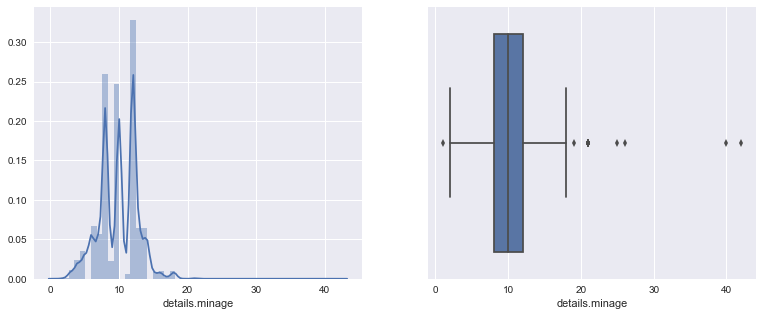

In [44]:
analyze_feature(df_data2, "details.minage")

We eliminated 1971 games based upon the parameter that the value of minimum age was zero, and are now left with 18396 records.

#### MinPlayers

count    18396.000000
mean         2.070450
std          0.662213
min          0.000000
25%          2.000000
50%          2.000000
75%          2.000000
max         10.000000
Name: details.minplayers, dtype: float64


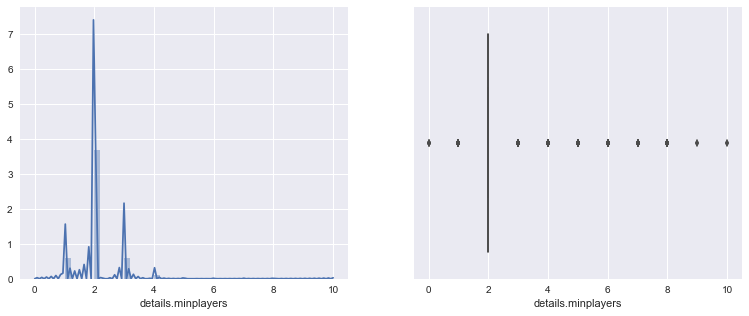

In [45]:
analyze_feature(df_data2, "details.minplayers")

We still see the issue that somes games have a minimum number of players that are equivalent to zero.  As stated above, we believe that this does not make logical sense and we will filter these games out.  

In [46]:
df_data3 = df_data2[(df_data2['details.minplayers']>=1)]

In [47]:
df_data2['details.minage'].count()-df_data3['details.minage'].count()

4

In [48]:
df_data3['details.minplayers'].describe()

count    18392.000000
mean         2.070900
std          0.661581
min          1.000000
25%          2.000000
50%          2.000000
75%          2.000000
max         10.000000
Name: details.minplayers, dtype: float64

We have filtered out four games and now have 18392 records

#### Playing Time

count    18392.000000
mean        75.952371
std        499.378068
min          0.000000
25%         20.000000
50%         45.000000
75%         90.000000
max      60000.000000
Name: details.playingtime, dtype: float64


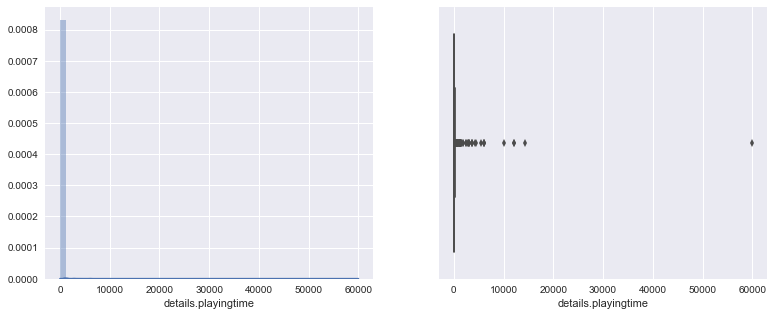

In [49]:
analyze_feature(df_data3, "details.playingtime")

In [50]:
df_data3.loc[df_data['details.playingtime']==60000]

,details.name,details.maxplayers,details.minage,details.minplayers,details.playingtime,details.yearpublished,stats.averageweight,stats.average,stats.owned,stats.stddev,Abstract Strategy,Action / Dexterity,Adventure,Age of Reason,American Civil War,American Indian Wars,American Revolutionary War,American West,Ancient,Animals,Arabian,Aviation / Flight,Bluffing,Book,Card Game,Children's Game,City Building,Civil War,Civilization,Collectible Components,Comic Book / Strip,Deduction,Dice,Economic,Educational,Electronic,Environmental,Expansion for Base-game,Exploration,Fan Expansion,Fantasy,Farming,Fighting,Game System,Horror,Humor,Industry / Manufacturing,Korean War,Mafia,Math,...,Area Control / Area Influence,Area Enclosure,Area Movement,Area-Impulse,Auction/Bidding,Betting/Wagering,Campaign / Battle Card Driven,Card Drafting,Chit-Pull System,Co-operative Play,Commodity Speculation,Crayon Rail System,Deck / Pool Building,Dice Rolling,Grid Movement,Hand Management,Hex-and-Counter,Line Drawing,Memory_mechanics,Modular Board,Paper-and-Pencil,Partnerships,Pattern Building,Pattern Recognition,Pick-up and Deliver,Player Elimination,Point to Point Movement,Press Your Luck,Rock-Paper-Scissors,Role Playing,Roll / Spin and Move,Route/Network Building,Secret Unit Deployment,Set Collection,Simulation,Simultaneous Action Selection,Singing,Stock Holding,Storytelling,Take That,Tile Placement,Time Track,Trading,Trick-taking,Variable Phase Order,Variable Player Powers,Voting,Worker Placement,binned.average,binary.success
4360,The Campaign for North Africa,10.0,14.0,8.0,60000.0,1979.0,5.0,5.62887,283.0,2.77789,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5.0,0


In [51]:
df_data3.loc[df_data3['details.playingtime']==0]

,details.name,details.maxplayers,details.minage,details.minplayers,details.playingtime,details.yearpublished,stats.averageweight,stats.average,stats.owned,stats.stddev,Abstract Strategy,Action / Dexterity,Adventure,Age of Reason,American Civil War,American Indian Wars,American Revolutionary War,American West,Ancient,Animals,Arabian,Aviation / Flight,Bluffing,Book,Card Game,Children's Game,City Building,Civil War,Civilization,Collectible Components,Comic Book / Strip,Deduction,Dice,Economic,Educational,Electronic,Environmental,Expansion for Base-game,Exploration,Fan Expansion,Fantasy,Farming,Fighting,Game System,Horror,Humor,Industry / Manufacturing,Korean War,Mafia,Math,...,Area Control / Area Influence,Area Enclosure,Area Movement,Area-Impulse,Auction/Bidding,Betting/Wagering,Campaign / Battle Card Driven,Card Drafting,Chit-Pull System,Co-operative Play,Commodity Speculation,Crayon Rail System,Deck / Pool Building,Dice Rolling,Grid Movement,Hand Management,Hex-and-Counter,Line Drawing,Memory_mechanics,Modular Board,Paper-and-Pencil,Partnerships,Pattern Building,Pattern Recognition,Pick-up and Deliver,Player Elimination,Point to Point Movement,Press Your Luck,Rock-Paper-Scissors,Role Playing,Roll / Spin and Move,Route/Network Building,Secret Unit Deployment,Set Collection,Simulation,Simultaneous Action Selection,Singing,Stock Holding,Storytelling,Take That,Tile Placement,Time Track,Trading,Trick-taking,Variable Phase Order,Variable Player Powers,Voting,Worker Placement,binned.average,binary.success
20,Gateway to the Stars,7.0,12.0,1.0,0.0,1981.0,3.0000,5.35714,80.0,1.673620,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5.0,0
50,Brauerei,6.0,14.0,3.0,0.0,1996.0,3.0000,5.83148,85.0,1.339370,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5.0,0
52,Sophie's World,6.0,12.0,2.0,0.0,1998.0,1.5714,4.93768,184.0,1.958640,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4.0,0
250,Neue Spiele im alten Rom,7.0,10.0,2.0,0.0,1994.0,2.1818,6.81040,390.0,1.359410,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6.0,0
251,Ostindiska Kompaniet,5.0,10.0,2.0,0.0,1991.0,2.5455,4.75000,196.0,1.599580,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4.0,0
439,Pacal,2.0,12.0,2.0,0.0,1999.0,1.6667,6.19779,132.0,1.043010,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6.0,0
482,Ice Blocks,2.0,10.0,2.0,0.0,2000.0,1.5000,5.38462,21.0,1.227160,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5.0,0
489,Flohzirkus,4.0,5.0,2.0,0.0,1997.0,1.0000,6.68182,28.0,1.108900,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6.0,0
491,Aerodrome,12.0,12.0,2.0,0.0,1994.0,2.1667,7.63393,60.0,1.344330,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7.0,1
581,Vox Populi,6.0,12.0,3.0,0.0,1999.0,2.1111,4.45733,200.0,1.629740,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,

We observe that there are a non-trivial number of games that have a playing time of 0 minutes.  We suspect that this is a data entry error and will filter these out.  It is reasonable to expect that there may be some games that take one minute, but are played in rapid succession.  We also observe the infamous "The Campaign for North Africa," which has been validated to being a beast of a game.  Because these data might impact the models, we will limit the maximum playing time of a game to be 3 standard deviations above the mean.

For more on The Campaign for North Africa, visit: https://kotaku.com/the-notorious-board-game-that-takes-1500-hours-to-compl-1818510912

In [52]:
df_data3['details.playingtime'].std()*3

1498.1342046629006

In [53]:
df_data4 = df_data3[(df_data3['details.playingtime']>=1) & (df_data3['details.playingtime']<=1499)]

In [54]:
df_data3['details.playingtime'].count()-df_data4['details.playingtime'].count()

975

count    17417.000000
mean        69.913073
std         85.272529
min          1.000000
25%         25.000000
50%         45.000000
75%         90.000000
max       1440.000000
Name: details.playingtime, dtype: float64


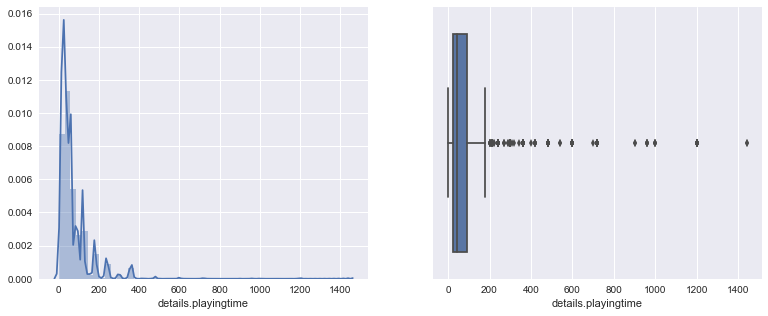

In [55]:
analyze_feature(df_data4, "details.playingtime")

We have removed 975 games and have 17417 records in our dataframe.

#### Year Published

count    17417.000000
mean      2002.295344
std         13.755996
min       1901.000000
25%       1996.000000
50%       2006.000000
75%       2013.000000
max       2018.000000
Name: details.yearpublished, dtype: float64


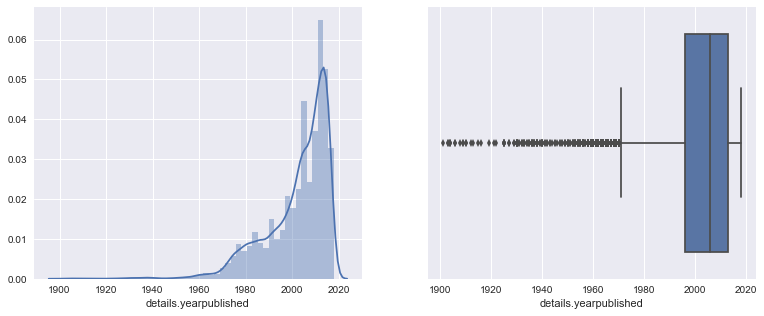

In [56]:
analyze_feature(df_data4, "details.yearpublished")

The distribution of board games appears to be skewed left, with the vast prepondarnce of the records published in the last two or so decades.  No abnormalities were identified in the records.

#### Board Game Category

In [57]:
#What are the first and last in the categories?
print(cats_selector[0])
print(cats_selector[-1])

Abstract Strategy
Zombies


In [58]:
#Get the column positions
print(df_data4.columns.get_loc('Abstract Strategy'))
print(df_data4.columns.get_loc('Zombies')+1)

10
94


In [59]:
df_data4.iloc[:, 10:94]

,Abstract Strategy,Action / Dexterity,Adventure,Age of Reason,American Civil War,American Indian Wars,American Revolutionary War,American West,Ancient,Animals,Arabian,Aviation / Flight,Bluffing,Book,Card Game,Children's Game,City Building,Civil War,Civilization,Collectible Components,Comic Book / Strip,Deduction,Dice,Economic,Educational,Electronic,Environmental,Expansion for Base-game,Exploration,Fan Expansion,Fantasy,Farming,Fighting,Game System,Horror,Humor,Industry / Manufacturing,Korean War,Mafia,Math,Mature / Adult,Maze,Medical,Medieval,Memory_category,Miniatures,Modern Warfare,Movies / TV / Radio theme,Murder/Mystery,Music,Mythology,Napoleonic,Nautical,Negotiation,Novel-based,Number,Party Game,Pike and Shot,Pirates,Political,Post-Napoleonic,Prehistoric,Print & Play,Puzzle,Racing,Real-time,Religious,Renaissance,Science Fiction,Space Exploration,Spies/Secret Agents,Sports,Territory Building,Trains,Transportation,Travel,Trivia,Video Game Theme,Vietnam War,Wargame,Word Game,World War I,World War II,Zombies
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


In [60]:
s_cat_overivew = df_data4.iloc[:, 10:94].sum()

In [61]:
df_cat_overivew = pd.Series.to_frame(s_cat_overivew)

In [62]:
df_cat_overivew[0].describe()

count      84.000000
mean      529.452381
std       702.365820
min         2.000000
25%       149.500000
50%       278.000000
75%       637.250000
max      4809.000000
Name: 0, dtype: float64

We see that across all the categories, the minimum number of board games per one category is two, and the maximum is 4809, with an average of approximately 529 to each category.

#### Board Game Mechanic

In [63]:
#What are the first and last in the categories?
print(mechs_selector[0])
print(mechs_selector[-1])

Acting
Worker Placement


In [64]:
#Get the column positions
print(df_data4.columns.get_loc('Acting'))
print(df_data4.columns.get_loc('Worker Placement')+1)

94
145


In [65]:
df_data4.iloc[:, 94:145]

,Acting,Action / Movement Programming,Action Point Allowance System,Area Control / Area Influence,Area Enclosure,Area Movement,Area-Impulse,Auction/Bidding,Betting/Wagering,Campaign / Battle Card Driven,Card Drafting,Chit-Pull System,Co-operative Play,Commodity Speculation,Crayon Rail System,Deck / Pool Building,Dice Rolling,Grid Movement,Hand Management,Hex-and-Counter,Line Drawing,Memory_mechanics,Modular Board,Paper-and-Pencil,Partnerships,Pattern Building,Pattern Recognition,Pick-up and Deliver,Player Elimination,Point to Point Movement,Press Your Luck,Rock-Paper-Scissors,Role Playing,Roll / Spin and Move,Route/Network Building,Secret Unit Deployment,Set Collection,Simulation,Simultaneous Action Selection,Singing,Stock Holding,Storytelling,Take That,Tile Placement,Time Track,Trading,Trick-taking,Variable Phase Order,Variable Player Powers,Voting,Worker Placement
0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0
3,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [66]:
s_mechs_overivew = df_data4.iloc[:, 94:145].sum()

In [67]:
df_mechs_overview = pd.Series.to_frame(s_mechs_overivew)

In [68]:
df_mechs_overview

,0
Acting,189
Action / Movement Programming,244
Action Point Allowance System,805
Area Control / Area Influence,1044
Area Enclosure,174
Area Movement,883
Area-Impulse,72
Auction/Bidding,965
Betting/Wagering,319
Campaign / Battle Card Driven,376


In [69]:
df_mechs_overview[0].describe()

count      51.000000
mean      714.392157
std       734.973607
min        26.000000
25%       268.000000
50%       461.000000
75%       887.000000
max      3718.000000
Name: 0, dtype: float64

We see that across all the mechanics, the minimum number of board games per one mechanic is is 26, and the maximum is 3718, with an average of approximately 714 to each mechanic.

#### Average Weight

count    17417.000000
mean         1.873099
std          0.899252
min          0.000000
25%          1.200000
50%          1.833300
75%          2.500000
max          5.000000
Name: stats.averageweight, dtype: float64


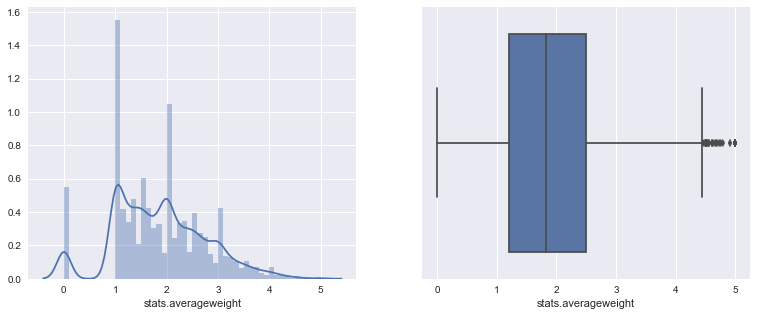

In [70]:
analyze_feature(df_data4, "stats.averageweight")

BoardGameGeek has five categorical variables for "weight" which answers the question: "How heavy (difficult/complex) is this game?"  Light = 1, Medium Light = 2, Medium = 3, Medium Heavy = 4, and Heavy = 5.  Consequently, any board games with a weight of less than 1 should be eliminated, and anything above 5 should be eliminated as well.

In [71]:
df_data5 = df_data4[(df_data4['stats.averageweight']>=1)]

In [72]:
df_data4['stats.averageweight'].count()-df_data5['stats.averageweight'].count()


956

count    16461.000000
mean         1.981882
std          0.800007
min          1.000000
25%          1.318200
50%          1.933300
75%          2.500000
max          5.000000
Name: stats.averageweight, dtype: float64


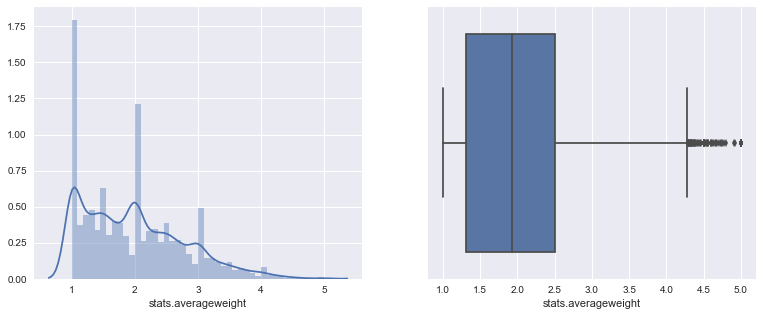

In [73]:
analyze_feature(df_data5, "stats.averageweight")

We removed 956 games from our record and now have 16461.

#### Average Score

count    16461.000000
mean         6.200449
std          0.959954
min          1.226530
25%          5.609620
50%          6.241110
75%          6.855570
max          9.411770
Name: stats.average, dtype: float64


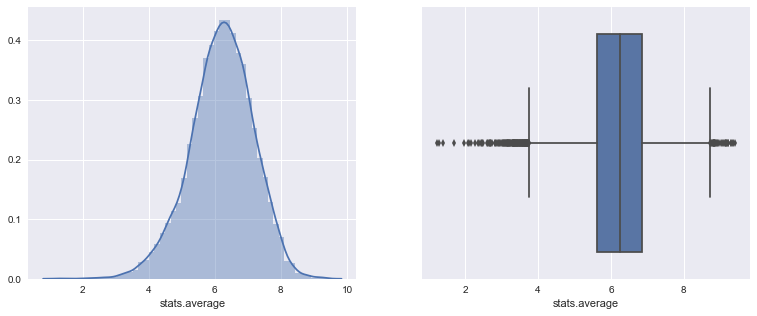

In [74]:
analyze_feature(df_data5, "stats.average")

Scores can range from 1 to 10, and from investigating the data, we see a small left-skew, but no data to be concerned about.

#### Average Owned

count    16461.000000
mean       882.566065
std       3172.514864
min          1.000000
25%         67.000000
50%        176.000000
75%        542.000000
max      95401.000000
Name: stats.owned, dtype: float64


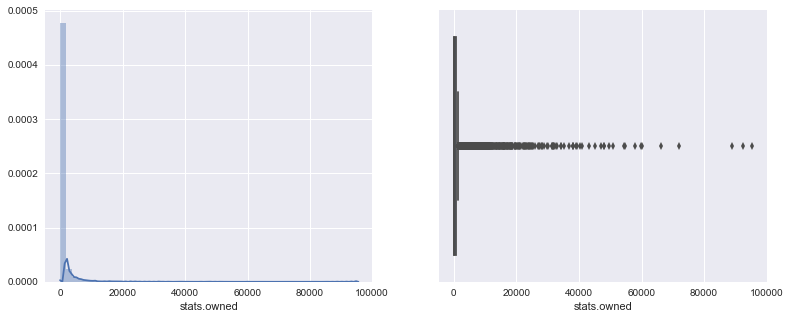

In [75]:
analyze_feature(df_data5, "stats.owned")

In [76]:
df_data.loc[df_data['stats.owned']==95401]

,details.name,details.maxplayers,details.minage,details.minplayers,details.playingtime,details.yearpublished,stats.averageweight,stats.average,stats.owned,stats.stddev,Abstract Strategy,Action / Dexterity,Adventure,Age of Reason,American Civil War,American Indian Wars,American Revolutionary War,American West,Ancient,Animals,Arabian,Aviation / Flight,Bluffing,Book,Card Game,Children's Game,City Building,Civil War,Civilization,Collectible Components,Comic Book / Strip,Deduction,Dice,Economic,Educational,Electronic,Environmental,Expansion for Base-game,Exploration,Fan Expansion,Fantasy,Farming,Fighting,Game System,Horror,Humor,Industry / Manufacturing,Korean War,Mafia,Math,...,Area Control / Area Influence,Area Enclosure,Area Movement,Area-Impulse,Auction/Bidding,Betting/Wagering,Campaign / Battle Card Driven,Card Drafting,Chit-Pull System,Co-operative Play,Commodity Speculation,Crayon Rail System,Deck / Pool Building,Dice Rolling,Grid Movement,Hand Management,Hex-and-Counter,Line Drawing,Memory_mechanics,Modular Board,Paper-and-Pencil,Partnerships,Pattern Building,Pattern Recognition,Pick-up and Deliver,Player Elimination,Point to Point Movement,Press Your Luck,Rock-Paper-Scissors,Role Playing,Roll / Spin and Move,Route/Network Building,Secret Unit Deployment,Set Collection,Simulation,Simultaneous Action Selection,Singing,Stock Holding,Storytelling,Take That,Tile Placement,Time Track,Trading,Trick-taking,Variable Phase Order,Variable Player Powers,Voting,Worker Placement,binned.average,binary.success
12,Catan,4.0,10.0,3.0,120.0,1995.0,2.3603,7.26569,95401.0,1.44842,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,7.0,1


Without a sufficent enough sample size of games being owned, statistics and data derived from these data may not be robust.  Consequently we will limit the minimum number of games that are "owned" to a lower limit of 30.

In [77]:
df_data6 = df_data5[(df_data5['stats.owned']>=30)]

In [78]:
df_data5['stats.owned'].count()-df_data6['stats.owned'].count()

1199

count    15262.000000
mean       950.305334
std       3285.209893
min         30.000000
25%         83.000000
50%        202.500000
75%        600.000000
max      95401.000000
Name: stats.owned, dtype: float64


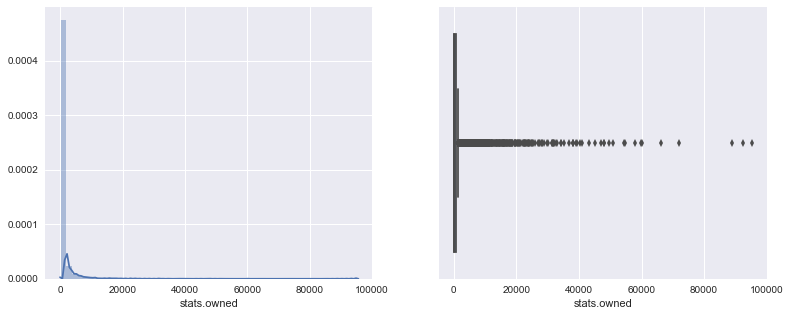

In [79]:
analyze_feature(df_data6, "stats.owned")

We observe we removed 1199 games because they were owned less than 30 times.  Our record set is 15262.  

#### Average Score St.Dev

count    15262.000000
mean         1.495717
std          0.301227
min          0.369966
25%          1.297735
50%          1.454630
75%          1.646840
max          3.958430
Name: stats.stddev, dtype: float64


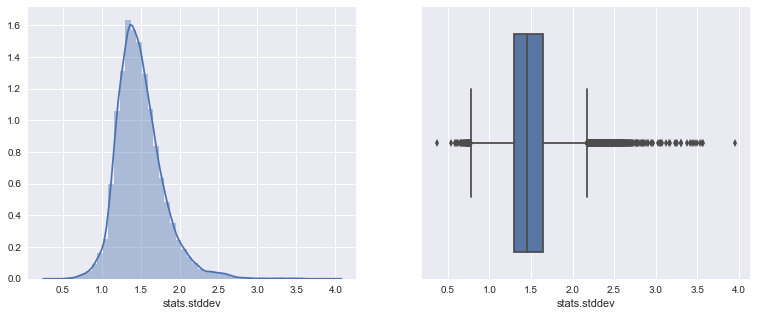

In [80]:
analyze_feature(df_data6, "stats.stddev")

Average Score St.dev does not need to be changed too significantly, because there are no errors or supsicious data.

## Creating Data Sets  
In order to properly design and validate our learning models, we will need three sets of data:  
  - Training Data
  - Development Data
  - Test Data   

First, though, we want to filter our game data by publishing year. As discussed above, we're interested in the shift in board game design in recent years. So, we'll create two data sets: one from 2000 to present, and one from 1980 to 1995.  

In [81]:
new_games_df = df_data6[(df_data6['details.yearpublished'] > 2000)]

old_games_df = df_data6[(df_data6['details.yearpublished'] > 1980) & 
                    (df_data6['details.yearpublished'] < 1995)]

print("New games shape: " + str(new_games_df.shape) + "; Old games shape: " + str(old_games_df.shape))

New games shape: (10084, 147); Old games shape: (2260, 147)


Now we can create the training, dev, and test sets.  
We'll use a We'll use a split of 70% / 10% / 20% for the new games, since we'll be developing models based on these games. Each will be randomly selected from the dataframe of entries.  
For the old games, we'll separate only a training set and a test set. (We won't do model development with the old games; we'll simply apply the model developed for the newer games.)  

In [82]:
#Split the new/old game DF into features and outcomes:
new_games_df_features = new_games_df.drop(["stats.average", "binned.average", 
                                           "stats.stddev", "stats.owned", "details.name", "binary.success"], axis = 1)
new_game_df_outcomes = new_games_df[["stats.average", "binned.average", "stats.stddev", "stats.owned", "binary.success"]]
old_games_df_features = old_games_df.drop(["stats.average", "binned.average",
                                           "stats.stddev", "stats.owned", "details.name", "binary.success"], axis = 1)
old_games_df_outcomes = old_games_df[["stats.average", "binned.average", "stats.stddev", "stats.owned", "binary.success"]]

In [83]:
# create a random arrangement of the data sets
# New Games
np.random.seed(0)
shuffle_new = np.random.permutation(np.arange(new_games_df_features.shape[0]))
shuffle_old = np.random.permutation(np.arange(old_games_df_features.shape[0]))
#Convert all data frames into Nump Arrays:
new_games_df_feat = new_games_df_features.values
new_games_df_out = new_game_df_outcomes.values
old_game_df_feat = old_games_df_features.values
old_game_df_out = old_games_df_outcomes.values

In [84]:
# create a random arrangement of the data sets

shuffled_new_feat = new_games_df_feat[shuffle_new]
shuffled_new_out = new_games_df_out[shuffle_new]

shuffled_old_feat = old_game_df_feat[shuffle_old]
shuffled_old_out = old_game_df_out[shuffle_old]

print(shuffled_new_feat.shape) #we expect to still see 10084 rows and 141 features
print(shuffled_new_out.shape) #we expect to still see 10084 rows and 5 features
print(shuffled_old_feat.shape) #we expect to still see 2260 rows and 141 features
print(shuffled_old_out.shape) #we expect to still see 2260 rows and 5 features

(10084, 141)
(10084, 5)
(2260, 141)
(2260, 5)


In [85]:
#Splitting into Training, Dev, and Test Sets - Note: won't include a dev set for Old Games

#Get the number of Records
n_new_games = shuffled_new_feat.shape[0]
n_old_games = shuffled_old_feat.shape[0]
print(n_new_games)
print(n_old_games)

#Split:

10084
2260


In [86]:
#New Game data sets

new_split1 = int(np.floor(.7*n_new_games)) # 70% for training
new_split2 = new_split1 + int(np.floor(.1*n_new_games)) + 1  # 10% for dev

print(new_split1, new_split2)

new_train_data = shuffled_new_feat[:new_split1]
new_train_labels = shuffled_new_out[:new_split1]

new_dev_data = shuffled_new_feat[new_split1:new_split2]
new_dev_labels = shuffled_new_out[new_split1:new_split2]

new_test_data = shuffled_new_feat[new_split2:]
new_test_labels = shuffled_new_out[new_split2:]

print("Training shape: " + str(new_train_data.shape) + "; Dev shape: " + str(new_dev_data.shape) + "; Test shape: " + str(new_test_data.shape))
print(np.ma.size(new_train_data,0)+np.ma.size(new_dev_data,0)+np.ma.size(new_test_data,0))

7058 8067
Training shape: (7058, 141); Dev shape: (1009, 141); Test shape: (2017, 141)
10084


In [87]:
# Old game data sets
old_split1 = int(np.floor(.7*n_old_games)) # 70% for training


old_train_data = shuffled_old_feat[:old_split1]
old_train_labels = shuffled_old_out[:old_split1]

old_test_data = shuffled_old_feat[old_split1:]
old_test_labels = shuffled_old_out[old_split1:]

print("Training shape: " + str(old_train_data.shape) + "; Test shape: " + str(old_test_data.shape))
print(np.ma.size(old_train_data,0)+np.ma.size(old_test_data,0))


Training shape: (1582, 141); Test shape: (678, 141)
2260


## Modeling - kNN  
The first model we are attempting is a k-Nearest-Neighbors model. This will find board games similar to the one in question, and use them to predict the rating of the unknown game. This seems similar to how real life works - players use similar games to decide whether to buy a new game - so it's worth a shot here!

In [88]:
from sklearn.neighbors import KNeighborsClassifier


k_values = [1,3,5,7,9]

for k in k_values:  
    ## MODEL USING BINARY SUCCESS (TWO CATEGORIES FOR OUTCOME)
    binary_kNN = KNeighborsClassifier(n_neighbors = k)
    binary_kNN.fit(new_train_data, new_train_labels[:,4]) # binary_success is in column 4
    # take a stab at the dev set
    y_pred = binary_kNN.predict(new_dev_data)
    # accuracy
    binary_acc = round(sum(y_pred == new_dev_labels[:,4])/new_dev_labels.shape[0],3)*100
    print("\nThe binary classifier with k=" + str(k) + " had an accuracy of " + str(binary_acc) + "%." )
    
    ## MODEL USING STAR RATING, 0-10 (TEN CATEGORIES FOR OUTCOME)
    ten_kNN = KNeighborsClassifier(n_neighbors = k)
    ten_kNN.fit(new_train_data, new_train_labels[:,1]) # binned star rating is in column 1
    # take a stab at the dev set
    y_pred = ten_kNN.predict(new_dev_data)
    # accuracy
    ten_acc = round(sum(y_pred == new_dev_labels[:,1])/new_dev_labels.shape[0],3)*100
    # what if you consider +/- 1 star to be still "accurate"?
    ten_acc2 = round((
        sum(y_pred == new_dev_labels[:,1]) + 
        sum(y_pred == new_dev_labels[:,1]-1) + sum(y_pred == new_dev_labels[:,1]+1)
        )/new_dev_labels.shape[0],3)*100
    print("The 1-10 scale classifier with k=" + str(k) + " had an accuracy of " 
          + str(ten_acc) + "% (and a +/-1 star accuracy of " + str(ten_acc2) + "%)." )
    
# print the binary values the model gets wrong
print("\nThe ratings misclassified by the binary classifier were: ")
y_pred = binary_kNN.predict(new_dev_data)
binary_errors = new_dev_labels[y_pred != new_dev_labels[:,4],:]
print(str(binary_errors[0:15,1]) + "-- actual values")

# print the binned values the model gets wrong
print("\nThe ratings misclassified by the binned 0-10 classifier were: ")
y_pred = ten_kNN.predict(new_dev_data)
ten_errors = new_dev_labels[y_pred != new_dev_labels[:,1],:]
print(str(ten_errors[0:15,1]) + "-- actual values")
print(str(y_pred[y_pred != new_dev_labels[:,1]][0:15]) + "-- predicted values")


The binary classifier with k=1 had an accuracy of 77.3%.
The 1-10 scale classifier with k=1 had an accuracy of 39.2% (and a +/-1 star accuracy of 88.8%).

The binary classifier with k=3 had an accuracy of 79.2%.
The 1-10 scale classifier with k=3 had an accuracy of 39.3% (and a +/-1 star accuracy of 87.8%).

The binary classifier with k=5 had an accuracy of 79.2%.
The 1-10 scale classifier with k=5 had an accuracy of 42.9% (and a +/-1 star accuracy of 92.6%).

The binary classifier with k=7 had an accuracy of 79.4%.
The 1-10 scale classifier with k=7 had an accuracy of 44.1% (and a +/-1 star accuracy of 93.0%).

The binary classifier with k=9 had an accuracy of 78.9%.
The 1-10 scale classifier with k=9 had an accuracy of 44.4% (and a +/-1 star accuracy of 92.9%).

The ratings misclassified by the binary classifier were: 
[ 6.  7.  7.  6.  6.  7.  6.  7.  6.  7.  6.  7.  6.  7.  7.]-- actual values

The ratings misclassified by the binned 0-10 classifier were: 
[ 6.  5.  7.  6.  7.  5.

The kNN model works reasonably well! We are able to achieve about 80% accuracy categorizing games into binary 'success' (rating > 7 stars) and 'failure' (rating < 7 stars) categories. We can see from the printed error values that most of the errors occur in the 6-7 star range, which is right on the border of "success".  
If we maintain the full spread of the 10 binned star-rating categories (integer values 1,2,3...10), we are able to achieve only about 45% accuracy. However, if we concede that plus-or-minus one star is still an "accurate" prediction of rating, we are able to get an impressive accuracy above 90%! The output immediately above shows the true star rating listed above the star values predicted by the model. We can see that again, the mid-scale (5-8 star) range is the issue. 

Based on our trials with the development data, we can see that the parameter k=5 creates the best kNN model. We'll save the k=5 models for evaluation on our test data later.

In [89]:
# Keep k=5 models
binary_kNN = KNeighborsClassifier(n_neighbors = k)
binary_kNN.fit(new_train_data, new_train_labels[:,4]) # binary_success is in column 4

ten_kNN = KNeighborsClassifier(n_neighbors = k)
ten_kNN.fit(new_train_data, new_train_labels[:,1]) # binned star rating is in column 1

print("kNN models saved!")

kNN models saved!


## Modeling - Naive Bayes

Next, we'll attempt a Naive Bayes model to classify the games. Since our features are multi-valued, we'll use the MultinomialNB option. Naive Bayes assumes that all features are conditionally independent and predicts the probability of each label given the feature values. We know that at least some of our features are not independent (for example, gameplay mechanics likely have some effect on playing time), so the naive assumption is certainly not entirely accurate. However, we'll explore this model anyway.

In [90]:
from sklearn.naive_bayes import MultinomialNB

## BINARY SUCCESS MODEL
# Create and train the model
binary_NBmodel = MultinomialNB()
binary_NBmodel.fit(new_train_data, new_train_labels[:,4]) # binary success, column 4

# Predict values for dev data
y_pred = binary_NBmodel.predict(new_dev_data)
acc = round(sum(y_pred == new_dev_labels[:,4])/len(new_dev_labels), 3)*100
print("The Naive Bayes classifier predicted binary success with " + str(acc) + "% accuracy")

## BINNED SCALE MODEL
# Create and train the model
ten_NBmodel = MultinomialNB()
ten_NBmodel.fit(new_train_data, new_train_labels[:,1]) # binned 0-10 success, column 1

# Predict values for dev data
y_pred = ten_NBmodel.predict(new_dev_data)
acc = round(sum(y_pred == new_dev_labels[:,1])/len(new_dev_labels), 3)*100
# what if you consider +/- 1 star to be still "accurate"?
acc2 = round((
    sum(y_pred == new_dev_labels[:,1]) + 
    sum(y_pred == new_dev_labels[:,1]-1) + sum(y_pred == new_dev_labels[:,1]+1)
    )/new_dev_labels.shape[0],3)*100
print("and predicted the 1-10 binned star rating with " + str(acc) + 
      "% accuracy (+/-1 star with " + str(acc2) + "%). \n")

The Naive Bayes classifier predicted binary success with 73.6% accuracy
and predicted the 1-10 binned star rating with 34.1% accuracy (+/-1 star with 84.2%). 



Well, Naive Bayes didn't achieve accuracy as high as kNN. Still, there is one benefit - Naive Bayes is a generative model, so we could actually use this model to "create" a new board game. The model can tell us the ideal playtime, number of players, mechanic, etc. Then it would be up to us to design a story and title to fit that mold!  
In that spirit, let's take a look at which game mechanics and themes are the most likely to create a successful game.

In [91]:
# feature probabilities for SUCCESS (outcome category 1)
probs = np.exp(binary_NBmodel.feature_log_prob_[1,:])
coefs = binary_NBmodel.coef_

# game themes are in columns 6 through 89
new_games_df_features.columns.tolist()[6:90]
top_feat_inds = np.fliplr([np.argsort(probs[6:90])[-5:]])[0]

for i in top_feat_inds:
    print("The theme " + new_games_df_features.columns.tolist()[6:90][i] + 
          " has a probability of " +  str(round(probs[6:90][i],5)*100) + "% in a successful game.")

print("\n")

# game mechanics are in columns 91 through the end
new_games_df_features.columns.tolist()[90:]
top_feat_inds = np.fliplr([np.argsort(probs[90:])[-5:]])[0]

for i in top_feat_inds:
    print("The mechanic " + new_games_df_features.columns.tolist()[90:][i] + 
          " has a probability of " +  str(round(probs[90:][i],5)*100) + "% in a successful game.")

The theme Wargame has a probability of 0.012% in a successful game.
The theme Card Game has a probability of 0.011% in a successful game.
The theme Fantasy has a probability of 0.008% in a successful game.
The theme Economic has a probability of 0.006% in a successful game.
The theme Science Fiction has a probability of 0.005% in a successful game.


The mechanic Dice Rolling has a probability of 0.015% in a successful game.
The mechanic Hand Management has a probability of 0.012% in a successful game.
The mechanic Variable Player Powers has a probability of 0.01% in a successful game.
The mechanic Area Control / Area Influence has a probability of 0.007% in a successful game.
The mechanic Card Drafting has a probability of 0.006% in a successful game.


Looks like the more successful modern games have themes of wargames, card games, fantasy, economy, and science fiction. That certainly matches what we know from experience! The preferred mechanics are dice rolling, hand management, variable player powers, area control, and card drafting (aka deck building). Again, that is what we have seen in our favorite games!

## Modeling - Linear Regression
Finally, we'll try a linear regression model for board game rating. This time, we'll use the full continous scale of rating (1-10, with decimal values included), since the model doesn't have to assign outcomes to countable categories.

In [92]:
from sklearn.linear_model import LinearRegression

# linear regression model
Regmodel = LinearRegression()
Regmodel.fit(new_train_data, new_train_labels[:,0]) # raw star values are in column 0

print("The linear regression model achieves an R2 value of " + str(Regmodel.score(new_dev_data, new_dev_labels[:,0])))

y_pred = Regmodel.predict(new_dev_data)
print("At worst, the predicted score was off by " + str(round(np.max(y_pred - new_dev_labels[:,0]),3)) + " stars.\n")

The linear regression model achieves an R2 value of 0.460947761954
At worst, the predicted score was off by 3.058 stars.



This linear regression model achieved an R2 of less than 0.5, and star ratings predicted within about 3 stars of the true value. Not the best performance - our kNN model is still winning. However, linear regression is wonderfully interpretable - the model here tells us the most important features in predicting success of a game.

In [93]:
# what are the most important features?
coefs = Regmodel.coef_
top_feat_inds = np.fliplr([np.argsort(coefs)[-7:]])[0]
bottom_feat_inds = np.argsort(coefs)[0:7]

# features that bring rating up
for i in top_feat_inds:
    print("The feature " + new_games_df_features.columns.tolist()[i] + 
          " has a coefficient of " +  str(coefs[i]))
print("\n")
# features that bring rating down
for i in bottom_feat_inds:
    print("The feature " + new_games_df_features.columns.tolist()[i] + 
          " has a coefficient of " +  str(coefs[i]))

The feature Vietnam War has a coefficient of 0.491231458653
The feature American Indian Wars has a coefficient of 0.465557998552
The feature Napoleonic has a coefficient of 0.462687194417
The feature Crayon Rail System has a coefficient of 0.456555073874
The feature Game System has a coefficient of 0.427079240971
The feature Book has a coefficient of 0.412035099255
The feature stats.averageweight has a coefficient of 0.410222939636


The feature Roll / Spin and Move has a coefficient of -0.331455259955
The feature Movies / TV / Radio theme has a coefficient of -0.285456798849
The feature Mature / Adult has a coefficient of -0.284711811953
The feature Singing has a coefficient of -0.183744475696
The feature Number has a coefficient of -0.181778425733
The feature Zombies has a coefficient of -0.162301453659
The feature Trading has a coefficient of -0.146409417658


Looks like having a game themed on a historical war (Vietnam, American Indian, or Napoleonic) brings success, as does having a book theme. The "stats.averageweight" feature corresponds to gameplay difficulty; seems like more complex games help increase the player satisfaction rating!  
On the other hand, having a game that requires rolling/spinning and moving (like traditional Monopoly or Life), singing, or trading all decrease satisfaction. Having mature/adult content, a movie/TV/radio theme, or a zombie theme also spells doom for game reception.  

# Evaluation of Models on Test Data
This section passes the test data through the three model types we built above. As we saw with the dev data, the kNN model performs the best.

In [94]:
## kNN MODELS
    # BINARY - evaluate the test data
y_pred = binary_kNN.predict(new_test_data)
    # accuracy
acc = round(sum(y_pred == new_test_labels[:,4])/new_test_labels.shape[0],3)*100
print("\nThe binary kNN classifier had an accuracy of " + str(acc) + "%." )
    
    # BINNED - evaluate the test data
y_pred = ten_kNN.predict(new_test_data)
    # accuracy
acc = round(sum(y_pred == new_test_labels[:,1])/new_test_labels.shape[0],3)*100
    # what if you consider +/- 1 star to be still "accurate"?
acc2 = round((
    sum(y_pred == new_test_labels[:,1]) + 
    sum(y_pred == new_test_labels[:,1]-1) + sum(y_pred == new_test_labels[:,1]+1)
    )/new_test_labels.shape[0],3)*100
print("The binned 1-10 scale kNN classifier had an accuracy of " 
      + str(acc) + "%, or " + str(acc2) +  "% if you allow for +/-1 star.")


The binary kNN classifier had an accuracy of 80.6%.
The binned 1-10 scale kNN classifier had an accuracy of 48.4%, or 93.5% if you allow for +/-1 star.


In [95]:
## Naive Bayes MODELS
    # BINARY - evaluate the test data
y_pred = binary_NBmodel.predict(new_test_data)
    # accuracy
acc = round(sum(y_pred == new_test_labels[:,4])/new_test_labels.shape[0],3)*100
print("\nThe binary Naive Bayes classifier had an accuracy of " + str(acc) + "%." )
    
    # BINNED - evaluate the test data
y_pred = ten_NBmodel.predict(new_test_data)
    # accuracy
acc = round(sum(y_pred == new_test_labels[:,1])/new_test_labels.shape[0],3)*100
    # what if you consider +/- 1 star to be still "accurate"?
acc2 = round((
    sum(y_pred == new_test_labels[:,1]) + 
    sum(y_pred == new_test_labels[:,1]-1) + sum(y_pred == new_test_labels[:,1]+1)
    )/new_test_labels.shape[0],3)*100
print("The binned 1-10 scale Naive Bayes classifier had an accuracy of " 
      + str(acc) + "%, or " + str(acc2) +  "% if you allow for +/-1 star.")


The binary Naive Bayes classifier had an accuracy of 76.4%.
The binned 1-10 scale Naive Bayes classifier had an accuracy of 35.1%, or 84.9% if you allow for +/-1 star.


In [96]:
## Linear Regression model
print("The linear regression model achieves an R2 value of " + str(Regmodel.score(new_test_data, new_test_labels[:,0])))
y_pred = Regmodel.predict(new_test_data)
print("On average, the predicted score was off by " + str(round(np.average(np.abs(y_pred - new_test_labels[:,0])),3)) + " stars.")
print("At worst, the predicted score was off by " + str(round(np.max(y_pred - new_test_labels[:,0]),3)) + " stars.")

The linear regression model achieves an R2 value of 0.437876935045
On average, the predicted score was off by 0.509 stars.
At worst, the predicted score was off by 4.966 stars.


# Analysis of "Old" Games
Now that we understand what features make a modern board game successful, we can analyze games from 1980 through 1995 to see how things have changed. We'll use the Naive Bayes approach to explore the most important features, since it had a better accuracy than Linear Regression in our experiments.  

In [97]:
## BINARY SUCCESS MODEL
# Create and train the model
binary_NBmodel = MultinomialNB()
binary_NBmodel.fit(old_train_data, old_train_labels[:,4]) # binary success, column 4

# Predict values for dev data
y_pred = binary_NBmodel.predict(old_test_data)
acc = round(sum(y_pred == old_test_labels[:,4])/len(old_test_labels), 3)*100
print("The Naive Bayes classifier predicted binary success with " + str(acc) + "% accuracy")

## BINNED SCALE MODEL
# Create and train the model
ten_NBmodel = MultinomialNB()
ten_NBmodel.fit(old_train_data, old_train_labels[:,1]) # binned 0-10 success, column 1

# Predict values for dev data
y_pred = ten_NBmodel.predict(old_test_data)
acc = round(sum(y_pred == old_test_labels[:,1])/len(new_dev_labels), 3)*100
# what if you consider +/- 1 star to be still "accurate"?
acc2 = round((
    sum(y_pred == old_test_labels[:,1]) + 
    sum(y_pred == old_test_labels[:,1]-1) + sum(y_pred == old_test_labels[:,1]+1)
    )/old_test_labels.shape[0],3)*100
print("and predicted the 1-10 binned star rating with " + str(acc) + 
      "% accuracy (+/-1 star with " + str(acc2) + "%). \n")

The Naive Bayes classifier predicted binary success with 78.0% accuracy
and predicted the 1-10 binned star rating with 17.2% accuracy (+/-1 star with 75.1%). 



In [98]:
# feature probabilities for SUCCESS (outcome category 1)
probs = np.exp(binary_NBmodel.feature_log_prob_[1,:])
coefs = binary_NBmodel.coef_

# game themes are in columns 6 through 89
old_games_df_features.columns.tolist()[6:90]
top_feat_inds = np.fliplr([np.argsort(probs[6:90])[-5:]])[0]

for i in top_feat_inds:
    print("The theme " + old_games_df_features.columns.tolist()[6:90][i] + 
          " has a probability of " +  str(round(probs[6:90][i],5)*100) + "% in a successful game.")

print("\n")

# game mechanics are in columns 91 through the end
old_games_df_features.columns.tolist()[90:]
top_feat_inds = np.fliplr([np.argsort(probs[90:])[-5:]])[0]

for i in top_feat_inds:
    print("The mechanic " + old_games_df_features.columns.tolist()[90:][i] + 
          " has a probability of " +  str(round(probs[90:][i],5)*100) + "% in a successful game.")

The theme Wargame has a probability of 0.031% in a successful game.
The theme World War II has a probability of 0.014% in a successful game.
The theme Science Fiction has a probability of 0.005% in a successful game.
The theme Miniatures has a probability of 0.005% in a successful game.
The theme Modern Warfare has a probability of 0.004% in a successful game.


The mechanic Hex-and-Counter has a probability of 0.022% in a successful game.
The mechanic Dice Rolling has a probability of 0.015% in a successful game.
The mechanic Simulation has a probability of 0.011% in a successful game.
The mechanic Variable Player Powers has a probability of 0.004% in a successful game.
The mechanic Action Point Allowance System has a probability of 0.003% in a successful game.


Looks like things have in fact changed a bit in the last 25 years! Wargames and Science Fiction were popular back then (and still are). However, the other front-running themes were World War II, Mineatures, and Modern Warfare. Perhaps that makes sense, considering that 1980 was still feeling the impact of American involvement in World War II and Vietnam.  
As for mechanics, dice rolling and variable player powers were popular - and still are today. Otherwise, hex-and-counter, simulation, and action point allowance games were the trends of the last millenium.  

# Summary
In this analysis, we constructed three types of models to explore the features that make modern board games successful. 
  * A k-Nearest-Neighbors approach gave us the best results, with the ability to predict the 0-10 star rating with over 90% accuracy (allowing +/-1 star margin)
  * Naive Bayes modeling helped us understand the themes and gameplay mechanics that most correspond to high ratings
  * Linear Regression models explored the full, continuous rating scale and helped us understand which features most strongly predict success - and failure!  
  
We learned that dice-rolling and variable player power games are perennial favorites, as are games with Science Fiction and Wargame themes. However, modern games have pivoted some, and new mechanics such as hand management, card drafting, and area control have replaced the old world of miniatures and simulation.  